In [1]:
#change working directory, for moduls of other package
import os
os.chdir(os.path.abspath('../../../../00_src'))

In [2]:
import numpy as np
import random
from dotenv import load_dotenv
from pathlib import Path
from agents.agent_ollama import AgentOllama
from environment.environment import SokobanEnvImpl
import environment.util as env_util
import environment.const as env_const
import environment.visualization as env_vis
from knowledge_graph.knowledge_graph import KnowledgeGraph
from langchain_neo4j import Neo4jGraph
from langchain_ollama import ChatOllama
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from typing import List
from typing_extensions import TypedDict
from langchain_core.output_parsers import StrOutputParser
from IPython.display import Image, display
from langgraph.graph import END, START, StateGraph
%matplotlib inline

In [3]:
load_dotenv(dotenv_path=Path("./.env"))

# URI examples: "neo4j://localhost", "neo4j+s://xxx.databases.neo4j.io"
URI = os.getenv("NEO4J_URI")
USERNAME = os.getenv("NEO4J_USERNAME")
PASSWORD = os.getenv("NEO4J_PASSWORD")

In [4]:
graph = Neo4jGraph(url=URI, username=USERNAME, password=PASSWORD)
llm_agent = ChatOllama(model="qwen3:8b", temperature=0, extract_reasoning=True)
llm_coder = ChatOllama(model="qwen2.5-coder:7b", temperature=0, extract_reasoning=True)

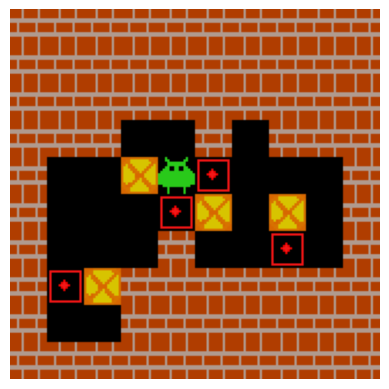

In [5]:
UP, DOWN, LEFT, RIGHT = env_const.UP, env_const.DOWN, env_const.LEFT, env_const.RIGHT
WALL, FLOOR, BOX_TARGET, BOX_ON_TARGET, BOX, PLAYER = env_const.WALL, env_const.FLOOR, env_const.BOX_TARGET, env_const.BOX_ON_TARGET, env_const.BOX, env_const.PLAYER
env = SokobanEnvImpl(max_steps=60, use_default_env=True)
kg = KnowledgeGraph(env)
env_vis.render(env=env, dpi=100)

# LangGraph View

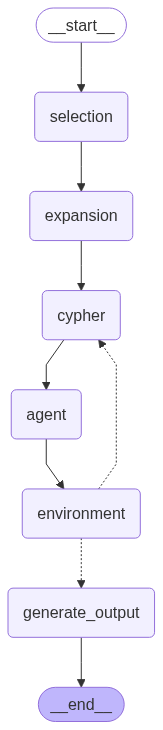

In [6]:
class InputState(TypedDict):
    ignore: None


class OverallState(TypedDict):
    selection_id: int
    selection_trajectory: List[int]
    expansion_action_id: int
    database_records: List[dict]
    next_step: str
    next_state: str
    reward: float


class OutputState(TypedDict):
    reward: float

def selection(state: InputState) -> OverallState:
    return {}

def expansion(state: OverallState) -> OverallState:
    return {}

def cypher(state: OverallState) -> OverallState:
    return {}

def agent(state: OverallState) -> OverallState:
    return {}

def environment(state: OverallState) -> OverallState:
    return {"next_state":random.choice(["generate_output", "cypher"])}

def generate_output(state: OverallState) -> OutputState:
    return {}
    

def environment_condition(
    state: OverallState,
) -> Literal["generate_output", "cypher"]:
    if state.get("next_state") == "generate_output":
        return "generate_output"
    elif state.get("next_state") == "cypher":
        return "cypher"

langgraph_view = StateGraph(OverallState, input=InputState, output=OutputState)
langgraph_view.add_node(selection)
langgraph_view.add_node(expansion)
langgraph_view.add_node(cypher)
langgraph_view.add_node(agent)
langgraph_view.add_node(environment)
langgraph_view.add_node(generate_output)

langgraph_view.add_edge(START, "selection")
langgraph_view.add_edge("selection", "expansion")
langgraph_view.add_edge("expansion", "cypher")
langgraph_view.add_edge("cypher", "agent")
langgraph_view.add_edge("agent", "environment")
langgraph_view.add_conditional_edges(
    "environment",
    environment_condition,
)
langgraph_view.add_edge("generate_output", END)

langgraph_view = langgraph_view.compile()

# View
display(Image(langgraph_view.get_graph().draw_mermaid_png()))

# LangGraph

In [7]:
class InputState(TypedDict):
    ignore: None


class OverallState(TypedDict):
    selection_id: int
    selection_trajectory: List[int]
    expansion_action_id: int
    database_records: List[dict]
    next_step: str
    next_state: str
    reward: float


class OutputState(TypedDict):
    reward: float

In [8]:
def selection(state: InputState) -> OverallState:
    records, summary, keys =  kg.client.read("""
                            MATCH (p:Path)-[:MOVE]->(c:Path)
                            WHERE c.done = false
                            WITH p, c,
                                 size([ (p)-[:MOVE]->(x) | x ]) AS p_simulations,
                                 size([ (c)-[:MOVE]->(x) | x ]) AS c_simulations
                            WHERE c_simulations < size(c.possible_actions)
                            WITH p, c, p_simulations, c_simulations,
                                 ((c.reward+6/size(c.trajectory)) + 0.2 * sqrt(log(toFloat(p_simulations)) / (toFloat(c_simulations) + 0.00001))) AS score
                            RETURN p, c, p_simulations, c_simulations, score
                            ORDER BY score DESC
                            LIMIT 1
                            """)
    if len(records) != 1:
          raise Exception("No further paths can be examined.")
    return {"selection_id":records[0]["c"]["id"], "selection_trajectory":records[0]["c"]["trajectory"]}

In [9]:
def doStep(action:int) -> bool:
    observation, reward_last, done, info = env.step(action)
    kg.step(action, reward_last, done)
    return observation, reward_last, done, info

def expansion(state: OverallState) -> OverallState:
     id = state.get("selection_id")
     trajectory = state.get("selection_trajectory")
     env.set_state(trajectory)
     kg.set_state(trajectory)

     actions = kg.get_possible_actions()
     records, summary, keys =  kg.client.read("""
                            MATCH (p:Path)-[m:MOVE]->(c:Path)
                            WHERE p.id = {id}
                            RETURN m
                            """.format(id=id))
     for record in records:
          actions.remove(record["m"]["id"])
     
     expansion_action_id = random.choice(actions)
     doStep(expansion_action_id)
     return {"expansion_action_id":expansion_action_id}

In [10]:
def cypher(state: OverallState) -> OutputState:
    next_action = env_util.breadth_first_search(env)[0]
    records, summary, keys =  kg.client.read("""
                            MATCH (a:Action)
                            WHERE a.id = {id}
                            RETURN a
                            """.format(id=next_action))
    return {"database_records": records}

In [11]:
generate_final_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a player which tries to solve a Sokoban game. Keep the reasoning short.",
        ),
        (
            "human",
            (
                """Use the following results retrieved from a database to provide
the next action for the Sokoban game.

Respond only with a single action out of "UP", "DOWN", "LEFT" or "RIGHT".

Results: {results}
Action: """
            ),
        ),
    ]
)

generate_final_chain = generate_final_prompt | llm_agent | StrOutputParser()


def agent(state: OverallState) -> OutputState:
    """
    Decides if the question is related to movies.
    """
    next_step = generate_final_chain.invoke(
        {"results": state.get("database_records")}
    )
    return {"next_step": next_step}

In [12]:
caption_action_map = {"UP":UP, "DOWN":DOWN, "LEFT":LEFT, "RIGHT":RIGHT}

def environment(state: OverallState) -> OverallState:
     next_step = state.get("next_step")

     next_action = 0 # default do nothing
     for action_id in caption_action_map.keys():
        if action_id in next_step:
            next_action = caption_action_map.get(action_id)

     observation, reward_last, done, info = doStep(next_action)

     next_state = "generate_output" if done or reward_last>5 else "cypher"

     return {"reward":reward_last, "next_state":next_state}

In [13]:
def generate_output(state: OverallState) -> OutputState:
    return {"reward":state.get("reward")}

In [14]:
def environment_condition(
    state: OverallState,
) -> Literal["generate_output", "cypher"]:
    if state.get("next_state") == "generate_output":
        return "generate_output"
    elif state.get("next_state") == "cypher":
        return "cypher"

In [15]:
langgraph = StateGraph(OverallState, input=InputState, output=OutputState)
langgraph.add_node(selection)
langgraph.add_node(expansion)
langgraph.add_node(cypher)
langgraph.add_node(agent)
langgraph.add_node(environment)
langgraph.add_node(generate_output)

langgraph.add_edge(START, "selection")
langgraph.add_edge("selection", "expansion")
langgraph.add_edge("expansion", "cypher")
langgraph.add_edge("cypher", "agent")
langgraph.add_edge("agent", "environment")
langgraph.add_conditional_edges(
    "environment",
    environment_condition,
)
langgraph.add_edge("generate_output", END)

langgraph = langgraph.compile()

### Run

In [16]:
# init all root steps
for action in kg.get_possible_actions():
    observation, reward_last, done, info = doStep(action)
    env.set_state([])
    kg.set_state([])

In [17]:
langgraph.invoke({"ignore": ""}, {"recursion_limit": 200})

{'reward': 10.9}

In [18]:
env.reset()
trajectory = [1,3,2,4,4,4,4,2,3,2,3,1,3,3,2,3,3,2,2,4,1,3,1,1,4,4,2,3,1,3,2]
env_vis.animate(env=env, path=trajectory, save_ani="../03_resource/09_LLM_KG/02_search_tree/output/01_lang_graph.gif", dpi=300)